In [23]:
import seaborn as sns
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet

In [1]:
def compute_expec_loss_cond_epsilon(Z_i_star, V, sigma):
    """
    Compute the given expression in PyTorch.
    
    Args:
        Z_i_star (torch.Tensor): The Z_{i*} vector, shape (p,1).
        V (torch.Tensor): The V matrix, shape (p,p).
        sigma (float): The standard deviation (scalar).
        
    Returns:
        torch.Tensor: The loss and derivative of the loss with respect to V
    """
    # Initialize normal distribution for standard normal
    normal = Normal(0, 1)

    # Compute intermediate values
    term = -V @ Z_i_star / sigma  # Shape: scalar
    phi = normal.log_prob(term).exp()  # \phi(x), scalar
    Phi = normal.cdf(term)  # \Phi(x), scalar

    # Compute the element-wise operations
    vec = (phi +  term * Phi) * sigma
    
    # Final computation
    loss = torch.sum(vec)
    deriv = - Phi @ Z_i_star.T
    
    return  loss, deriv



def compute_raw_loss(Z_i_star, V, sigma):
    """
    Compute the given loss in PyTorch.
    
    Args:
        Z_i_star (torch.Tensor): The Z_{i*} vector, shape (p,1).
        V (torch.Tensor): The V matrix, shape (p,p).
        sigma (float): The standard deviation (scalar).
        
    Returns:
        torch.Tensor: The result of the expression, shape (p,).
    """
    p = Z_i_star.shape[0]
    noise_gauss = Normal(0, sigma)
    relu = nn.ReLU()
    
    epsilon = noise_gauss.sample((p,)).view(p,1)
    loss = torch.sum(relu((- Z_i_star - epsilon).T @ V))
    return loss
    
    
def proj_Op_tangent_space_at_W(M, W):
    """
    Projects a matrix M onto the tangent space of the orthogonal group O_p at W.
    
    Parameters:
        M (torch.Tensor or np.ndarray): The matrix to be projected, of shape (p, p).
        W (torch.Tensor or np.ndarray): A point in the orthogonal group O_p, of shape (p, p)
                                         
    Returns:
        torch.Tensor or np.ndarray: The projection of M onto the tangent space of O_p at W,
                                    of shape (p, p).
    """
    proj = W @ (W.T @ M - M.T @ W) / 2
    return proj
    

def sample_Z_i_star(p):
    """
    Samples Z_i_star uniformly from the standard basis of R^p.
    
    Args:
        p (int): Dimension of the space R^p.
        
    Returns:
        torch.Tensor: A p-dimensional tensor representing the sampled standard basis vector.
    """
    # Create an identity matrix of shape (p, p) where rows are standard basis vectors
    standard_basis = torch.eye(p)
    
    # Randomly choose one row (basis vector) uniformly
    idx = torch.randint(0, p, (1,)).item()
    Z_i_star = standard_basis[idx]
    
    return Z_i_star



In [62]:
def compute_expec_loss_cond_epsilon(Z_i_star, V, sigma):
    """
    Compute the given expression in PyTorch.
    
    Args:
        Z_i_star (torch.Tensor): The Z_{i*} vector, shape (p,1).
        V (torch.Tensor): The V matrix, shape (p,p).
        sigma (float): The standard deviation (scalar).
        
    Returns:
        torch.Tensor: The loss and derivative of the loss with respect to V
    """
    # Initialize normal distribution for standard normal
    normal = Normal(0, 1)

    # Compute intermediate values
    term = -V @ Z_i_star / sigma  # Shape: scalar
    phi = normal.log_prob(term).exp()  # \phi(x), scalar
    Phi = normal.cdf(term)  # \Phi(x), scalar

    # Compute the element-wise operations
    vec = (phi +  term * Phi) * sigma
    
    # Final computation
    loss = torch.sum(vec)
    deriv = - Phi @ Z_i_star.T
    
    return  loss, deriv


def compute_expec_deriv_discrete_2D(a, b, p, theta, sigma):
    
    """ theta ranges from 0 to 1 """

    normal = Normal(0, 1)
    theta = torch.tensor([theta * (2 * np.pi)], dtype = torch.float32)
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    V = torch.tensor([[cos_theta, -sin_theta],
                      [sin_theta,  cos_theta]])
    
    z1 = torch.Tensor([a, b]).view(2, 1)
    z2 = torch.Tensor([b, a]).view(2, 1)

    term_1 = -V @ z1 / sigma
    term_2 = -V @ z2 / sigma

    phi_1 = normal.log_prob(term_1).exp()
    phi_2 = normal.log_prob(term_2).exp()
    
    Phi_1 = normal.cdf(term_1)
    Phi_2 = normal.cdf(term_2)
    
    loss = torch.sum((phi_1 + term_1 * Phi_1) * sigma * p + (phi_2 + term_2 * Phi_2) * sigma * (1 - p)) 
    return loss
    

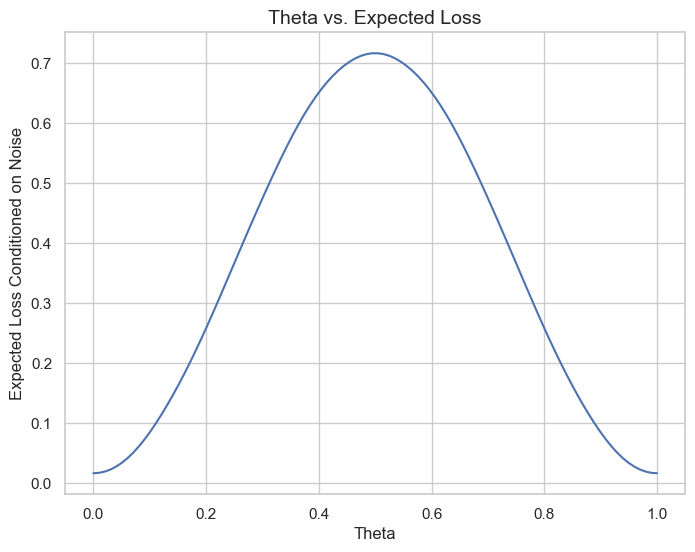

In [66]:
a, b, sigma = 0.2, 0.5, 0.2
p = 0.5
# Generate theta values and compute the outputs
theta_values = np.linspace(0, 1, 100)
y_values = [compute_expec_deriv_discrete_2D(a, b, p, theta, sigma).item() for theta in theta_values]

# Create a DataFrame for easier plotting with sns
data = pd.DataFrame({
    'Theta': theta_values,
    'Output': y_values
})

# Plot using seaborn
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(8, 6))
sns.lineplot(x='Theta', y='Output', data=data)
plt.title("Theta vs. Expected Loss", fontsize=14)
plt.xlabel("Theta", fontsize=12)
plt.ylabel("Expected Loss Conditioned on Noise", fontsize=12)
plt.show()

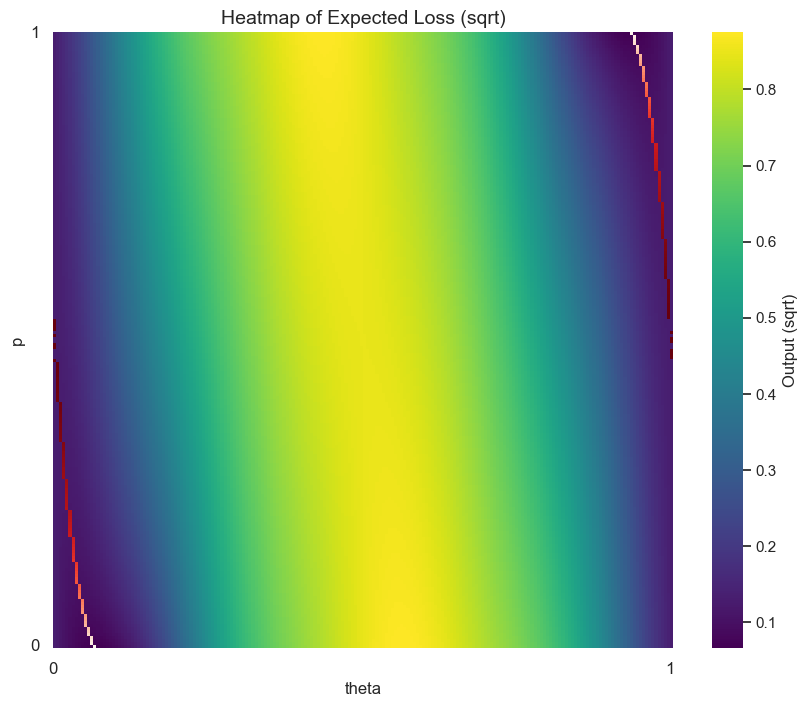

In [64]:
# Parameters
a, b, sigma = 0.2, 0.5, 0.2
grid_size = 200

# Generate grid for theta (x-axis) and p (y-axis)
theta_values = np.linspace(0, 1, grid_size)
p_values = np.linspace(0, 1, grid_size)

# Initialize output matrix
output_matrix = np.zeros((grid_size, grid_size))

# Compute the function over the grid with adjusted coordinate system
for i, p in enumerate(p_values):
    for j, theta in enumerate(theta_values):
        result = compute_expec_deriv_discrete_2D(a, b, p, theta, sigma)
        output_matrix[(grid_size - i) - 1, j] = result.sqrt().item()  # Flip the rows for correct visualization
        
# Create a mask for the row-wise minimums
highlight_matrix = np.zeros_like(output_matrix, dtype=bool)
for row_idx, row in enumerate(output_matrix):
    min_col_idx = np.argmin(row)  # Find the column index of the minimum
    highlight_matrix[row_idx, min_col_idx] = True  # Mark the minimum position
         

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(output_matrix, 
            xticklabels=False,  # Suppress default x-axis tick labels
            yticklabels=False,  # Suppress default y-axis tick labels
            cmap='viridis', 
            cbar_kws={'label': 'Output (sqrt)'})

# Overlay the red-highlighted heatmap for row minima
sns.heatmap(output_matrix, 
            xticklabels=False, 
            yticklabels=False, 
            cmap='Reds',  # Red colormap for highlighting
            cbar=False,  # No additional color bar
            mask=~highlight_matrix,  # Highlight only the minima
            alpha=1)  # Opaque for highlighted cells


# Add custom ticks for a Cartesian-like grid
plt.xticks([0, grid_size - 1], [0, 1], fontsize=12)  # Theta ticks
plt.yticks([grid_size - 1, 0], [0, 1], fontsize=12)  # P ticks (flipped correctly)

# Add axis labels and title
plt.xlabel("theta", fontsize=12)
plt.ylabel("p", fontsize=12)
plt.title("Heatmap of Expected Loss (sqrt)", fontsize=14)
plt.show()


In [14]:
# Example usage
p = 2
Z_i_star = sample_Z_i_star(p).view(p, 1)  # Example Z_{i*} vector (p=10)
# Z_i_star = torch.randn(p).view(p, 1)  # Example Z_{i*} vector (p=10)
V = torch.eye(p)        # Example V vector (p=10)
sigma = 1.0                 # Example scalar sigma

compute_raw_loss(Z_i_star, V, sigma),compute_expec_loss_cond_epsilon(Z_i_star, V, sigma)[0]

(tensor(0.3757), tensor(0.4823))

To verify empirically that the expectation computation, and the derivative computation is correct.

In [15]:
n, p = 10000, 2
sigma = 1.0 
V = torch.eye(p) 


raw_loss = []
conditional_epsilon = []

for i in range(n):
    Z_i_star = sample_Z_i_star(p).view(p, 1)
    # Z_i_star = dir_distr.sample((1,)).view(p, 1)  # Example Z_{i*} vector (p=10)
    conditional_epsilon.append(compute_expec_loss_cond_epsilon(Z_i_star, V, sigma)[0])
    raw_loss.append(compute_raw_loss(Z_i_star, V, sigma))
    
# Difference in mean
print(f"the difference between the mean raw loss and the mean loss conditional on epsilon is {torch.mean(torch.tensor(conditional_epsilon)) - torch.mean(torch.tensor(raw_loss))}" )

# Variance of the two lists
# print(torch.var(torch.tensor(conditional_epsilon)), torch.var(torch.tensor(raw_loss)))

V = torch.eye(p) 
V.requires_grad_(True)
result = compute_expec_loss_cond_epsilon(Z_i_star, V, sigma)
result[0].backward()
print(f"the difference between computed derivative and autograd is {torch.norm(V.grad - result[1])}")

the difference between the mean raw loss and the mean loss conditional on epsilon is -0.0009696483612060547
the difference between computed derivative and autograd is 1.4901161193847656e-08


In [16]:
n, p = 10000, 10
sigma = 0.1
V = torch.eye(p) 
dir_distr = Dirichlet(torch.ones(p)*5)


derivative_across_n = torch.zeros(p, p)

for i in range(n):
    # Z_i_star = sample_Z_i_star(p).view(p, 1)
    Z_i_star = dir_distr.sample((1,)).view(p, 1)  # Example Z_{i*} vector (p=10)
    derivative_across_n = derivative_across_n + compute_expec_loss_cond_epsilon(Z_i_star, V, sigma)[1]
    
avg_deriv = derivative_across_n/n

proj_avg_deriv = proj_Op_tangent_space_at_W(avg_deriv, V)

print(torch.norm(proj_Op_tangent_space_at_W(avg_deriv, V), p = "fro"))

tensor(0.0012)
